# Test score prediction

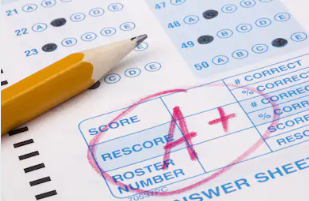

# Index

* [1. Import modules](#modules)
* [2. Read data](#read_data)
* [3. Data info](#info)
    * [3.1 NA Values](#navalues)
    * [3.2 Info plots](#info_plots)
        * [3.2.1 Schools](#schools)
        * [3.2.2 Schools settings](#settings)
        * [3.2.3 Type of schools](#type)
        * [3.2.4 Teaching methods](#methods)
* [4. Machine Learning Models](#models)
    * [4.1 Random Forest Regressor Model](#rf_regressor)
        * [4.1.1 Random Forest Regressor Plots](#rfr_plots)
    * [4.2 Linear Regression](#linear)
        * [4.2.1 Linear Regression Plots](#lr_plots)
* [5. Conclusion](#conclusion)

## 1. Import modules
<a id="modules"></a>

In [ ]:
# Basic libraries (Data Manipulation)
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# OS
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 2. Read data
<a id="read_data"></a>

In [ ]:
df = pd.read_csv("/kaggle/input/predict-test-scores-of-students/test_scores.csv")
df.head()

## 3. Data info
<a id="info"></a>

In [ ]:
rows = df.shape[0]
columns = df.shape[1]

print(f"This data frame has {rows} rows and {columns} columns.")

In [ ]:
df.info()

### 3.1 NA Values
<a id="navalues"></a>

In [ ]:
df.isna().sum()

### 3.2 Info plots
<a id="info_plots"></a>

#### 3.2.1 Schools
<a id="schools"></a>

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x="school", order=df["school"].value_counts().index)
plt.title("Number of students for each school")
plt.xticks(rotation=45)
plt.show()

In [ ]:
school_prtg = df["school"].value_counts()/len(df["school"]) * 100
print("Number of students in percentage for each school:\n")
print(school_prtg)

#### 3.2.2 Schools settings
<a id="settings"></a>

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=df, x="school_setting") # order=df["school_setting"].value_counts().index
plt.title("School settings")
plt.xlabel("School setting")
for value in ax.patches:
    ax.annotate("%d" % value.get_height(), (value.get_x() + value.get_width() / 2, value.get_height()),
                ha='center', va='bottom', fontsize=12, color="black")
plt.show()

In [ ]:
school_sttg = df["school_setting"].value_counts()/len(df["school_setting"]) * 100
print(school_sttg)

#### 3.2.3 Type of schools
<a id="type"></a>

In [ ]:
public = df.loc[df["school_type"] == "Public"]
private = df.loc[df["school_type"] == "Non-public"]

In [ ]:
labels = ["Public", "Non-public"]
values = [public.value_counts().sum(), private.value_counts().sum()]
colors = ['#2E86C1', '#A9CCE3']

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo="label+percent", textinfo="label", textfont_size=15,
                  marker=dict(colors=colors, line=dict(color="#1C2833", width=2)))
fig.update_layout(title={"text": "Type of schools"})
fig.show()

#### 3.2.4 Teaching methods
<a id="methods"></a>

In [ ]:
methods = df["teaching_method"].unique()
print(methods)

In [ ]:
standard = df.loc[df["teaching_method"] == "Standard"]
experimental = df.loc[df["teaching_method"] == "Experimental"]

In [ ]:
labels = ["Standard", "Experimental"]
values = [standard.value_counts().sum(), experimental.value_counts().sum()]
colors = ["#626567", "#CACFD2"]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo="label+percent", textinfo="label", textfont_size=15,
                 marker=dict(colors=colors, line=dict(color="#1C2833", width=2)))
fig.update_layout(title={"text": "Teaching methods"})
fig.show()

#### 3.2.5 Gender

In [ ]:
male = df.loc[df["gender"] == "Male"]
female = df.loc[df["gender"] == "Female"]

In [ ]:
labels = ["Male", "Female"]
values = [male.value_counts().sum(), female.value_counts().sum()]
colors = ["#0B5345", "#48C9B0"]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo="label+percent", textinfo="label", textfont_size=15,
                 marker=dict(colors=colors, line=dict(color="#1C2833", width=2)))
fig.update_layout(title={"text": "Gender"})
fig.show()

## 4. Machine Learning Models
<a id="models"></a>

In [ ]:
student_df = df.drop(["classroom"], axis=1)

df.drop(["classroom", "student_id"], axis=1, inplace=True)

In [ ]:
X = df.drop(["posttest"], axis=1)
y = df["posttest"]

student_id = student_df.drop(["posttest"], axis=1)
other = student_df["posttest"]

Now, we will convert **categorical** values to **numbers**.
<br>
This can be done manually, with a dict and edit each *categorical* value and replace them for a number.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categories = ["school", "school_setting", "school_type", "teaching_method", "gender", "lunch"]

encoder = OneHotEncoder()
transform = ColumnTransformer([("one_hot", encoder, categories)], remainder="passthrough")

X_transformed = transform.fit_transform(X)

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score

def model_evaluation(y_test, prediction):
    '''Show model score accuracy, with MAE and MSE'''
    
    MAE = mean_absolute_error(y_test, prediction)
    MSE = mean_squared_error(y_test, prediction)
    r2 = r2_score(y_test, prediction)
    
    print(f"Mean absolute error: {round(MAE, 3)}\nMean squared error: {round(MSE, 3)}\nR2: {round(r2, 3)}")

**Random state** show us same values for each run, this keep *train* and *test* split values, always the same.
<br>
As well, we have another split to keep *id_student* value and compare predicted values with the real values. With the same random_state, we don't have any problem beacuse the split has same index values to predicted values.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
ID_train, ID_test, other_train, other_test = train_test_split(student_id, other, test_size=0.2, random_state=42)

### 4.1 Random Forest Regressor Model
<a id="rf_regressor"></a>

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor()
regressor_model = rf_regressor.fit(X_train, y_train)
model_score = regressor_model.score(X_test, y_test)

print(f"Random Forest Regressor model score: {round(model_score, 2)}")
print(f"Random Forest Regressor model score (percentage): {round(model_score, 4) * 100} %")

In [ ]:
rf_prediction = regressor_model.predict(X_test)

model_evaluation(y_test, rf_prediction)

Loop for each value in *predicted* and *real scores*, to save the residual value in a lista and add those values in data frame.

In [ ]:
list_residual = []

for i, p in zip(y_test, rf_prediction):
    residual = i - p
    list_residual.append(round(residual, 3))

Save *predicted values* in data frame, and compare them with *real values*.

In [ ]:
test_scores = pd.DataFrame({"Stundet ID": ID_test.student_id, "Predicted scores": rf_prediction, "Real scores": y_test, "Residual": list_residual})
test_scores.head()

In [ ]:
test_scores.reset_index(drop=True, inplace=True)
test_scores.head()

#### 4.1.1 Random Forest Regressor Plots
<a id="rfr_plots"></a>

In [ ]:
plt.figure(figsize=(10, 8))
sns.regplot(data=test_scores, x="Real scores", y="Predicted scores", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.show()

In [ ]:
reg = sns.jointplot(data=test_scores, x="Real scores", y="Predicted scores", kind='reg')
regline = reg.ax_joint.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)

In [ ]:
plt.figure(figsize=(10, 8))
sns.regplot(data=test_scores, x="Predicted scores", y="Residual", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title("Random Forest Regression Residual plot")
plt.show()

### 4.2 Linear Regression
<a id="linear"></a>

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)

print(f"Linear Regression model score: {round(lr_score, 3)}")
print(f"Linear Regression model score (percentage): {round(lr_score, 4) * 100} %")

In [ ]:
lr_prediction = lr_model.predict(X_test)
model_evaluation(y_test, lr_prediction)

In [ ]:
list_residual = []

for i, p in zip(y_test, lr_prediction):
    residual = i - p
    list_residual.append(round(residual, 3))

In [ ]:
lr_test_scores = pd.DataFrame({"Stundet ID": ID_test.student_id, "Predicted scores": lr_prediction, "Real scores": y_test, "Residual": list_residual})
lr_test_scores.reset_index(drop=True, inplace=True)
lr_test_scores.head()

#### 4.2.1 Linear Regression Plots
<a id="lr_plots"></a>

In [ ]:
plt.figure(figsize=(10, 8))
sns.regplot(data=lr_test_scores, x="Real scores", y="Predicted scores", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title("Linear Regression plot")
plt.show()

In [ ]:
reg = sns.jointplot(data=lr_test_scores, x="Real scores", y="Predicted scores", kind='reg')
regline = reg.ax_joint.get_lines()[0]
regline.set_color('red')
regline.set_zorder(5)

In [ ]:
plt.figure(figsize=(10, 8))
sns.regplot(data=lr_test_scores, x="Predicted scores", y="Residual", scatter_kws={"color": "black"}, line_kws={"color": "red"})
plt.title("Linear Regression Residual plot")
plt.show()

## 5. Conclusion
<a id="conclusion"></a>

In [ ]:
models = pd.DataFrame({"Model": ["Random Forest Regression", "Linear Regression"], "Accuracy": [model_score, lr_score]})
models = models.sort_values(by="Accuracy", ascending=False)
models

In [ ]:
fig = px.bar(models, x="Accuracy", y="Model", orientation="h",
             color="Model", title="Regression Models accuracy score")
fig.show()

In this 2 models (*Random Forest Regression* and *Linear Regression*) we have **0,70%** difference between them!
<br>
But, as *Linear Regression* model has a higher value, I will save his predictions in CSV.

In [ ]:
csv_name = "students_test_score_prediction.csv"
lr_test_scores.to_csv(csv_name, index=False)
print(f"Your CSV file, ({csv_name}), has been saved!")